In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive


# Preliminary Analysis of Features

Loading the data

In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out= pd.read_csv(loc,**kwargs)
    return out

fname = ("Crime_Data_from_2020_to_Present.csv", "https://drive.google.com/file/d/1L1t5DnQvT9ti1-2RPaIvZdHVFJDiPoEC/view?usp=sharing")
df = getfile(fname)
df.head()

local file not found; accessing Google Drive


,,"<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv=""content-type"" content=""text/html; charset=utf-8""/><style nonce=""6Tfcqgy7TFnoYxzp3iAj_g"">/* Copyright 2022 Google Inc. All Rights Reserved. */"
.goog-inline-block{position:relative;display:-moz-inline-box;display:inline-block}* html .goog-inline-block{display:inline}*:first-child+html .goog-inline-block{display:inline}.goog-link-button{position:relative;color:#15c;text-decoration:underline;cursor:pointer}.goog-link-button-disabled{color:#ccc;text-decoration:none;cursor:default}body{color:#222;font:normal 13px/1.4 arial,sans-serif;margin:0}.grecaptcha-badge{visibility:hidden}.uc-main{padding-top:50px;text-align:center}#uc-dl-icon{display:inline-block;margin-top:16px;padding-right:1em;vertical-align:top}#uc-text{display:inline-block;max-width:68ex;text-align:left}.uc-error-caption,.uc-warning-caption{color:#222;font-size:16px}...


In [ ]:
df.columns

Index(['<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/><style nonce="6Tfcqgy7TFnoYxzp3iAj_g">/* Copyright 2022 Google Inc. All Rights Reserved. */'], dtype='object')

In [ ]:
for column in df.columns.values:
    print(f'{column} with {df[column].unique().shape[0]} unique values')

<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/><style nonce="6Tfcqgy7TFnoYxzp3iAj_g">/* Copyright 2022 Google Inc. All Rights Reserved. */ with 1 unique values


## Consolidating and Examining the Dates of Crimes

We first convert the dates to datetime objects, shown below

In [ ]:
df['Date Rptd'] = df['Date Rptd'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p").date())
df['DATE OCC'] = df['DATE OCC'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p").date())
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

We can take a look at which days of the week most crimes occurred

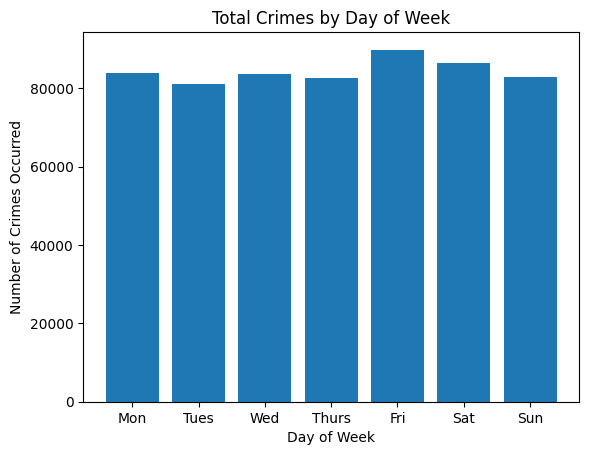

In [ ]:
plt.bar(df['DATE OCC'].dt.day_of_week.value_counts().sort_index().index, df['DATE OCC'].dt.day_of_week.value_counts().sort_index())
plt.xticks(ticks = df['DATE OCC'].dt.day_of_week.value_counts().sort_index().index, labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes Occurred')
plt.title('Total Crimes by Day of Week')
plt.show()
plt.close()

Shown above, most crimes take place during the start of the weekend

We can also take a look at which months most crimes occurred

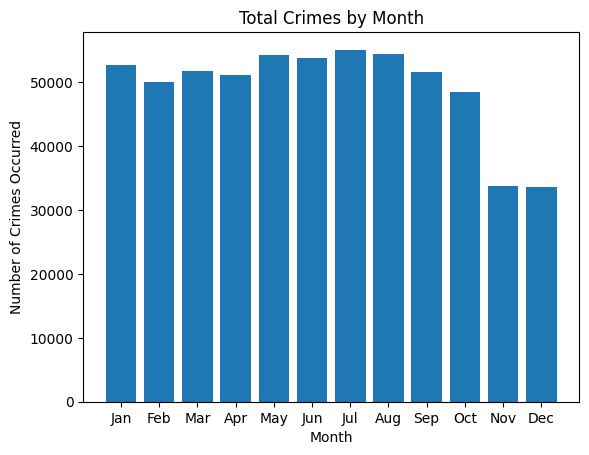

In [ ]:
plt.bar(df['DATE OCC'].dt.month.value_counts().sort_index().index, df['DATE OCC'].dt.month.value_counts().sort_index())
plt.xticks(ticks = df['DATE OCC'].dt.month.value_counts().sort_index().index, \
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Total Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes Occurred')
plt.show()
plt.close()

Evidently, crime occurs more over the summer and the start of the year

## Examining Crime Categories

We can look at the top 10 crime categories

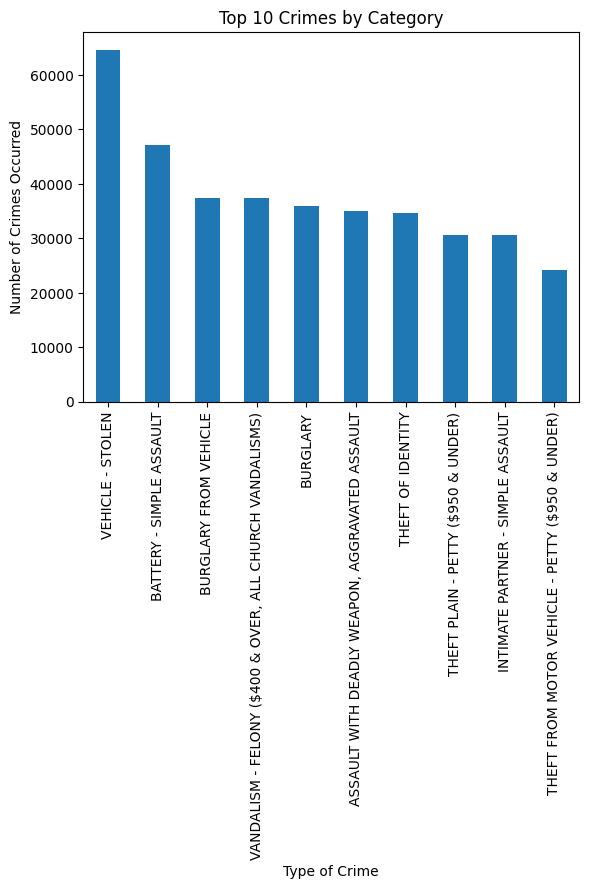

In [ ]:
df['Crm Cd Desc'].value_counts()[:10].plot(kind = 'bar')
plt.xlabel('Type of Crime')
plt.ylabel('Number of Crimes Occurred')
plt.title('Top 10 Crimes by Category')
plt.show()
plt.close()

## Crime Evolution Over Time

Since the ultimate task of this project involves a Recurrent Neural Network with a time component, it is in our interest to obtain a preliminary idea of how crime evolves over time

### Total Crimes Over Time

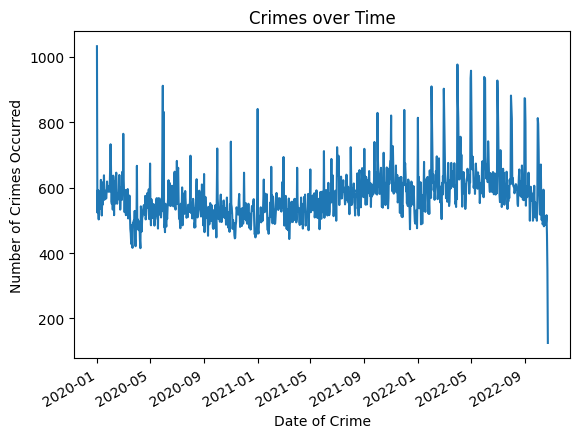

In [ ]:
plt.plot(df['DATE OCC'].value_counts().sort_index().index, df['DATE OCC'].value_counts().sort_index())
plt.xlabel('Date of Crime')
plt.ylabel('Number of Crimes Occurred')
plt.title('Crimes over Time')
plt.gcf().autofmt_xdate()
plt.show()
plt.close()

### Crimes Occurred over Years, Grouped by Month

We must first format the data such that it can be used

In [ ]:
df['Month OCC'] = df['DATE OCC'].dt.month
df['Year OCC'] = df['DATE OCC'].dt.year
month_year_occ = [str(m)+"/"+str(y) for m,y in zip(df["Month OCC"], df["Year OCC"])]
month_year_occ_formatted = [dt.datetime.strptime(d, "%m/%Y") for d in month_year_occ]
df["Month Year OCC"] = np.array(month_year_occ_formatted)

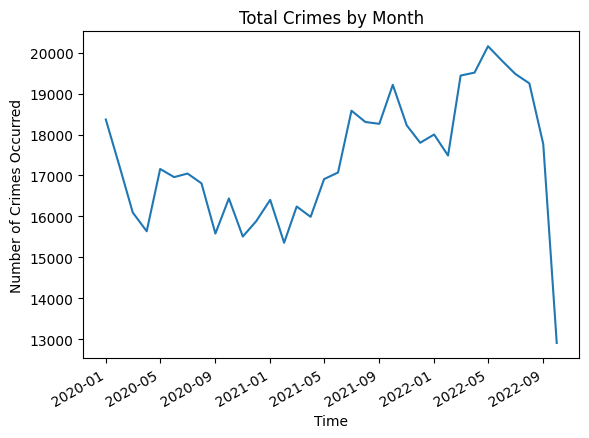

In [ ]:
plt.plot(df["Month Year OCC"].value_counts().sort_index().index, df["Month Year OCC"].value_counts().sort_index())
plt.gcf().autofmt_xdate()
plt.title('Total Crimes by Month')
plt.xlabel('Time')
plt.ylabel('Number of Crimes Occurred')
plt.show()
plt.close()

### Crimes by Time of Day

We first define a few functions to read the military time format

In [ ]:
# convert into 4-char strings
def makemil(time):
    ntime = ""
    if len(str(time)) == 1:
        ntime = "000" + str(time)
    if len(str(time)) == 2:
        ntime = "00" + str(time)
    if len(str(time)) == 3:
        ntime = "0" + str(time)
    if len(str(time)) == 4:
        ntime = str(time)
    return ntime

# function for retrieving the hour of the time
def returnhour(miltime):
    return miltime[:2]

In [ ]:
df["TIME OCC"] = df["TIME OCC"].apply(makemil)

Plotting the number of crimes by time of day

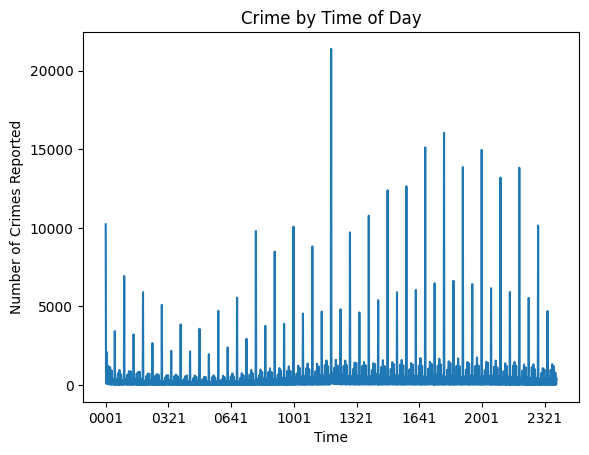

In [ ]:
df['TIME OCC'].value_counts().apply(int).sort_index().plot()
plt.xlabel('Time')
plt.ylabel('Number of Crimes Reported')
plt.title('Crime by Time of Day')
plt.show()
plt.close()

We see that most crimes occur around midnight, which will be a key observation for our RNN

### Crimes by the Hour

In [ ]:
df['Hour OCC'] =  df["TIME OCC"].apply(returnhour)

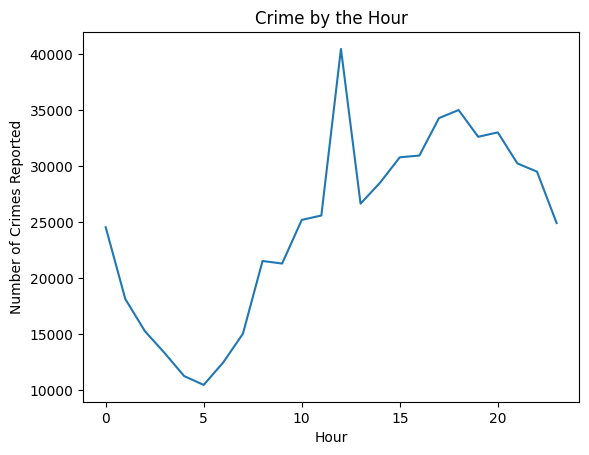

In [ ]:
df['Hour OCC'].apply(int).value_counts().apply(int).sort_index().plot()
plt.xlabel('Hour')
plt.ylabel('Number of Crimes Reported')
plt.title('Crime by the Hour')
plt.show()
plt.close()

Plotting the number of crimes reported against the hour of the day confirms our hypothesis above

### Dropping Unnecessary Columns

In [ ]:
# df.drop(columns = 'DR_NO', inplace = True) # DR number is all unique

# should we drop date rpt as well as we are solely intrested in the occurence of crimes?